# Worked examples with Ag 1000 Genomes data

## Preamble

In [1]:
import h5py
import allel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
fn = ("/data/coluzzi/ag1000g/data/phase1/release/AR3/variation/main/hdf5/" +
      "ag1000g.phase1.ar3.pass.3L.h5")

In [5]:
# open filehandle
fh = h5py.File(fn, "r")

In [6]:
# samples are held at the first level after chrom
# we decode them from the byte literal format
samples = [s.decode() for s in fh["3L"]["samples"][:]]
samples[:10]

['AB0085-C',
 'AB0087-C',
 'AB0088-C',
 'AB0089-C',
 'AB0090-C',
 'AB0091-C',
 'AB0092-C',
 'AB0094-C',
 'AB0095-C',
 'AB0097-C']

In [7]:
# read in the metadata using the pandas module
metadata = pd.read_csv(
    "/data/coluzzi/ag1000g/data/phase1/release/AR3/samples/samples.meta.txt", 
    index_col=0,
    sep="\t")

In [8]:
metadata.head()

,ox_code,src_code,sra_sample_accession,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,latitude,longitude
index,,,,,,,,,,,,,,,
0,AB0085-C,BF2-4,ERS223996,BFS,Burkina Faso,Pala,Austin Burt,Sam O'Loughlin,2012,S,F,89905852,28.01,11.150,-4.235
1,AB0087-C,BF3-3,ERS224013,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,116706234,36.76,11.233,-4.472
2,AB0088-C,BF3-5,ERS223991,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,112090460,23.30,11.233,-4.472
3,AB0089-C,BF3-8,ERS224031,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,145350454,41.36,11.233,-4.472
4,AB0090-C,BF3-10,ERS223936,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,105012254,34.64,11.233,-4.472


In [9]:
# positions dataset is in the "variants" group
positions = allel.SortedIndex(fh["/3L/variants/POS"][:])
positions

SortedIndex((9643193,), dtype=int32)
[    9790     9798     9812 ..., 41956541 41956551 41956556]

In [10]:
# genotype data is in the "calldata" group
g = allel.GenotypeChunkedArray(fh["3L"]["calldata"]["genotype"])
g

,0,1,2,3,4,...,760,761,762,763,764
0,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
1,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
2,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
3,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
4,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0


# Plot mean mq0 in windows across the genome

In [11]:
# scikit allel has a built in function that allows us to calculate statistics within windows
values, windows, counts = allel.stats.windowed_statistic(
    positions, fh["3L"]["variants/CoverageMQ0"][:], np.mean, 
    size=100000, start=0)

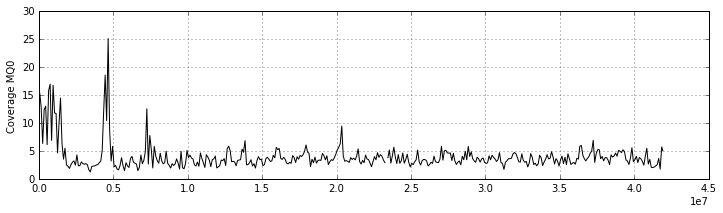

In [12]:
# using matplotlib here
fig = plt.figure(figsize=(12, 3))

ax = fig.add_subplot(111)

ax.plot(windows.mean(1), values, "k-")
ax.set_ylabel("Coverage MQ0")
ax.grid(True)

# Plot count of variants across the genome

NOTE: Accessibility likely to differ, this plot shows accessibility and diversity. ie if low we cannot tell if inaccessible or not diverse.

In [13]:
# again scikit-allel function
values, windows, counts = allel.stats.windowed_statistic(
    positions, positions, np.size, 
    size=100000, start=0)

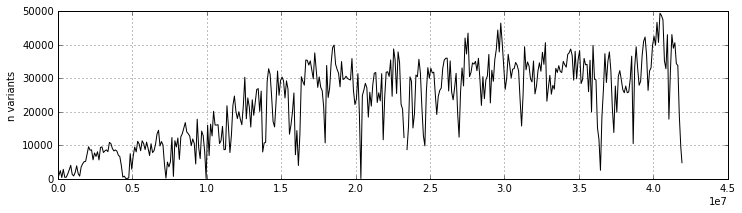

In [14]:
fig = plt.figure(figsize=(12, 3))

ax = fig.add_subplot(111)

ax.plot(windows.mean(1), values, "k-")
ax.set_ylabel("n variants")
ax.grid(True)

# Calculate Fst between two populations

For this we will need some metadata.
We compute the allele counts and use these to calculate Fst. 

In [15]:
# create a dictionary containing the indices of each subpopulation
subpops_ix = dict()
pop_groups = metadata.groupby("population")
for grp in pop_groups.groups:
    subpops_ix[grp] = [samples.index(x) for x in pop_groups.get_group(grp).ox_code]

In [16]:
# remove non biallelic variants
qq = np.array(g.max(axis=(1, 2)))

In [17]:
qq.shape, qq[:10]

((9643193,), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [18]:
g_bial = g.compress(condition=qq < 2, axis=0)

In [19]:
# count alleles within subpops
allele_counts = g_bial.count_alleles_subpops(subpops_ix)

In [20]:
# scikit allel has a built in function for windowed Fst
fst, windows, counts = allel.stats.windowed_patterson_fst(
    positions.compress(qq < 2), 
    allele_counts["BFM"], allele_counts["BFS"], size=100000, start=0)

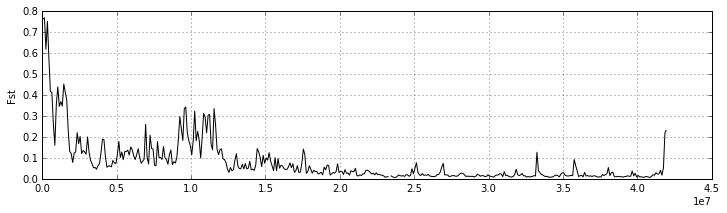

In [21]:
fig = plt.figure(figsize=(12, 3))

ax = fig.add_subplot(111)
ax.plot(windows.mean(1), fst, "k-")
ax.grid(True)
ax.set_ylabel("Fst")

# Plot number of variants in a KES sample vs CMS sample

In [22]:
# take the first sample from each population
kes_ix = metadata.loc[metadata.population=="KES"].index[0]
cms_ix = metadata.loc[metadata.population=="CMS"].index[0]

In [24]:
# use the is_het method from scikit allel
kes_hz = g.take([kes_ix], axis=1).is_het()
cms_hz = g.take([cms_ix], axis=1).is_het()

In [25]:
# and the windowed statistic function...
kes_count, windows, _ = allel.stats.windowed_statistic(
    pos=fh["/3L/variants/POS"][:], values=kes_hz,
    statistic=np.sum, start=0, size=100000)

In [26]:
cms_count, windows, _ = allel.stats.windowed_statistic(
    pos=fh["/3L/variants/POS"][:], values=cms_hz,
    statistic=np.sum, start=0, size=100000)

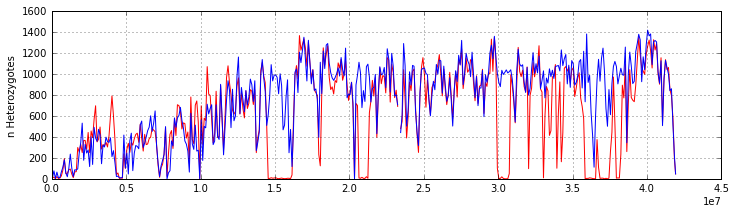

In [27]:
fig = plt.figure(figsize=(12, 3))

ax = fig.add_subplot(111)

ax.plot(windows.mean(1), kes_count, "r-")
ax.plot(windows.mean(1), cms_count, "b-")
ax.grid(True)
ax.set_ylabel("n Heterozygotes")

# Select a gene and list the NS variants

In [28]:
# start end of gene from vectorbase
tep1 = 11202091, 11206882

In [29]:
# locate the indices of the start/end
ix = positions.locate_range(*tep1)

In [30]:
# load the annotation object from hdf5
annotation = fh["3L"]["variants"]["ANN"][ix]

In [31]:
# create a table, but only keep rows in the gene
var_tab = allel.VariantChunkedTable(fh["3L"]["variants"], names=["POS", "ANN"], index="POS")
var_tab = var_tab[ix]

In [33]:
# define non synonymous mutations
non_syn = np.in1d(var_tab["ANN"]["Annotation_Impact"], (b"MODERATE", b"HIGH"))
non_syn.sum()

21

In [39]:
# show some columns from the data
xx = var_tab[non_syn]

xx["ANN"]["Annotation Feature_Type HGVS_c HGVS_p cDNA_pos cDNA_length CDS_pos".split()].display(limit=30)

Annotation,Feature_Type,HGVS_c,HGVS_p,cDNA_pos,cDNA_length,CDS_pos
b'missense_variant',b'transcript',b'n.3117C>A',b'p.His1039Gln',3117,4023,3117
b'missense_variant',b'transcript',b'n.2210A>G',b'p.Asn737Ser',2210,4023,2210
b'missense_variant',b'transcript',b'n.2207C>T',b'p.Pro736Leu',2207,4023,2207
b'missense_variant',b'transcript',b'n.2122A>T',b'p.Thr708Ser',2122,4023,2122
b'missense_variant',b'transcript',b'n.2044A>T',b'p.Thr682Ser',2044,4023,2044
b'missense_variant',b'transcript',b'n.2040G>C',b'p.Gln680His',2040,4023,2040
b'missense_variant',b'transcript',b'n.1948G>A',b'p.Glu650Lys',1948,4023,1948
b'missense_variant',b'transcript',b'n.1942T>A',b'p.Leu648Met',1942,4023,1942
b'missense_variant',b'transcript',b'n.1939A>C',b'p.Lys647Gln',1939,4023,1939
b'missense_variant',b'transcript',b'n.1902G>C',b'p.Leu634Phe',1902,4023,1902


# Select a gene and find variants > 5%

In [40]:
# ix, positions and g are defined above
# here we count alleles for a specific region in tep1, convert to frequencies 
# and take the maximum across rows, the MAF is 1 - this value.
maf = 1 - g[ix].count_alleles().to_frequencies().max(axis=1)

In [41]:
# given the positions in the gene, just show those above 5%
positions[ix][maf > 0.05]

SortedIndex((10,), dtype=int32)
[11204271 11204298 11204330 11204373 11204436 11204442 11204659 11205025
 11205026 11205037]